# Identify Spam in SMS Using Active Learning
This notebook is the 2nd and final part in a series analyzing the effect of Active Learning on classification tasks.

In the previous notebook, we've used the MNIST dataset.  
In this notebook, we'll use a dataset labeling SMS as spam/ham.  
The dataset is available for download at http://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# Read data into a DataFrame
df = pd.read_table('SMSSpamCollection', names=['y', 'text'])
df = df.sample(frac=1)
df.head()

FileNotFoundError: File b'SMSSpamCollection' does not exist

In [3]:
# Let's get basic summary statistics
df.groupby('y').describe()

text                                                               
     count unique                                                top freq
y                                                                        
ham   4825   4516                             Sorry, I'll call later   30
spam   747    653  Please call our customer service representativ...    4

### Analyzing a basic Classifier
Let's build a simple classifier.  
We first split our data into train (80%) and test (20%) sets.  

Our model will perform the following steps:
1. Remove stopwords
1. Count word occurrences
1. Perform Tf-Idf transformation on counts
1. Use a Multinomial Naive-Bayes classifier

In [4]:
# Split data to train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['y'], test_size=0.20, random_state=0)

In [5]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model = Pipeline([('vect', CountVectorizer(stop_words='english')),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB()),
])

In [6]:
# Fit the model on our train set
model.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        ...inear_tf=False, use_idf=True)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

### Evaluate Model Performance

In [7]:
model.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        ...inear_tf=False, use_idf=True)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [8]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, f1_score

In [9]:
print(classification_report(y_true=y_train,y_pred=model.predict(X_train)))

             precision    recall  f1-score   support

        ham       0.98      1.00      0.99      3860
       spam       1.00      0.87      0.93       597

avg / total       0.98      0.98      0.98      4457



In [10]:
print(classification_report(y_true=y_test,y_pred=model.predict(X_test)))

             precision    recall  f1-score   support

        ham       0.97      1.00      0.98       965
       spam       1.00      0.79      0.88       150

avg / total       0.97      0.97      0.97      1115



In [11]:
print(f1_score(y_true=y_test,y_pred=model.predict(X_test), average='macro'))

0.932143563527926


### Plot model confidence
Let's plot the confidence level of our model for different samples:

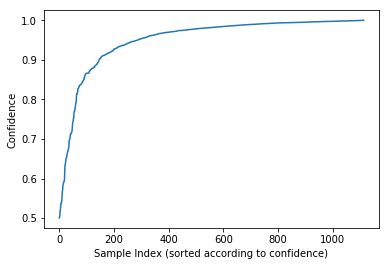

In [12]:
predicted_probabilities = np.max(model.predict_proba(X_test), axis=1)
sorted_predicted_probabilities_indices = np.argsort(predicted_probabilities)

plt.plot(sorted(predicted_probabilities))
plt.xlabel('Sample Index (sorted according to confidence)');
plt.ylabel('Confidence');

We can see that while the model is very confident for most of the samples, there are about 100 samples (~10%) with low confidence.  

Note that we define confidence as the prediction probability of the predicted class.  
Since there are only 2 classes, the minimal value of confidence in this case is 0.5.

Next, let's review some of examples that got the lowest confidence.  
We can see that in many of these cases, our model misclassifies them.

In [13]:
examples = [(y_test.iloc[x], model.predict([X_test.iloc[x]])[0], X_test.iloc[x]) for x in sorted_predicted_probabilities_indices[:20]]
pd.DataFrame(examples, columns=['y', 'prediction', 'text'])

,y,prediction,text
0,ham,ham,Yavnt tried yet and never played original either
1,spam,spam,I'd like to tell you my deepest darkest fantas...
2,spam,spam,RECPT 1/3. You have ordered a Ringtone. Your o...
3,spam,spam,Boltblue tones for 150p Reply POLY# or MONO# e...
4,spam,ham,"Bears Pic Nick, and Tom, Pete and ... Dick. In..."
5,spam,ham,Hottest pics straight to your phone!! See me g...
6,spam,spam,FREE2DAY sexy St George's Day pic of Jordan!Tx...
7,spam,ham,Reply with your name and address and YOU WILL ...
8,spam,spam,For taking part in our mobile survey yesterday...
9,spam,spam,Bloomberg -Message center +447797706009 Why wa...


Text(0,0.5,'Average accuracy')

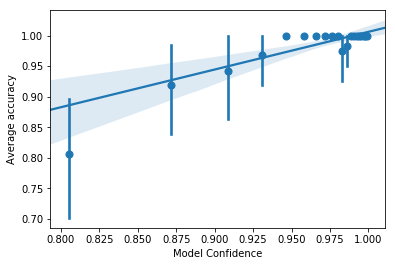

In [42]:
is_correct = (y_test == model.predict(X_test))
ax = sns.regplot(x=predicted_probabilities, y=is_correct, x_bins=20)
# ax = sns.regplot(x=predicted_probabilities, y=is_correct, x_bins=np.arange(0.1,1,.05))
plt.xlabel('Model Confidence')
plt.ylabel('Average accuracy')

### Learning Curve

In [49]:
train_set_size_list = [10,20,30,40,50,75,100,150,200,250,300,350,400,450] + list(np.arange(500,1500,100)) + list(np.arange(1700,5000,250)) + list(np.arange(5500,10000,500))
history = []

for train_set_size in train_set_size_list:
    model = Pipeline([('vect', CountVectorizer(stop_words='english')),
                         ('tfidf', TfidfTransformer()),
                         ('clf', MultinomialNB()),
    ])

    labeled_instances = X_train[:train_set_size]
    y_labeled_instances = y_train[:train_set_size]
    model.fit(labeled_instances, y_labeled_instances)
    
    history.append({"num_labels": len(labeled_instances),
                "labels": labeled_instances,
                "model": model,
                "accuracy_labeled_instances": accuracy_score(y_true=y_labeled_instances,y_pred=model.predict(labeled_instances)),
                "f1_labeled_instances": f1_score(y_true=y_labeled_instances,y_pred=model.predict(labeled_instances), average='macro'),
                "accuracy": accuracy_score(y_true=y_test,y_pred=model.predict(X_test)),
                "f1": f1_score(y_true=y_test,y_pred=model.predict(X_test), average='macro'),
               })


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:461: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is i

In [53]:
df['X'] = df['text']

In [57]:
def run_active_learner(df, model, num_samples_in_active_learning_batch, select_next_batch_func):
    al_history = []
    labeled = pd.DataFrame([])

    # We first mark all data points as unused. We'll update this column whenever we already used a data point.
    df['used']= False
    df['confidence'] = 0

    df = df.sample(frac=1)
    X_all = np.array(df['X'].tolist())

    for current_batch_size in num_samples_in_active_learning_batch:
        next_labels = select_next_batch_func(df, current_batch_size)

        next_label_indices = next_labels.index
        df.loc[next_label_indices, 'used'] = True

        labeled = labeled.append(next_labels)
        next_labels['step'] = len(labeled)

        X_labeled = np.array(labeled['X'].tolist())

        print('fitting a model for {} labeled instances...'.format(len(labeled)))

        model.fit(X_labeled, y=labeled['y'].values)

        probs = model.predict_proba(X_all)
        df['confidence'] = np.max(probs, axis=1)

        df['prediction'] = model.predict(X_all)

        al_history.append({"num_labeled": len(labeled),
                        "labeled": labeled,
                        "model": model,
                        "accuracy": accuracy_score(y_true=y_test,y_pred=model.predict(X_test)),
                        "f1": f1_score(y_true=y_test,y_pred=model.predict(X_test), average='macro')
                       })

    return al_history

In [58]:
def select_next_batch_func(df, batch_size):
    df = df.sort_values(by=['used','confidence'], ascending=[True,True])
    next_labels = df[:batch_size]
    return next_labels

In [59]:
num_samples_in_active_learning_batch = [50] + [10]*150
al_history_50_10 = run_active_learner(df, model, num_samples_in_active_learning_batch, select_next_batch_func)

fitting a model for 50 labeled instances...


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


fitting a model for 60 labeled instances...
fitting a model for 70 labeled instances...
fitting a model for 80 labeled instances...
fitting a model for 90 labeled instances...
fitting a model for 100 labeled instances...
fitting a model for 110 labeled instances...
fitting a model for 120 labeled instances...
fitting a model for 130 labeled instances...
fitting a model for 140 labeled instances...
fitting a model for 150 labeled instances...
fitting a model for 160 labeled instances...
fitting a model for 170 labeled instances...
fitting a model for 180 labeled instances...
fitting a model for 190 labeled instances...
fitting a model for 200 labeled instances...
fitting a model for 210 labeled instances...
fitting a model for 220 labeled instances...
fitting a model for 230 labeled instances...
fitting a model for 240 labeled instances...
fitting a model for 250 labeled instances...
fitting a model for 260 labeled instances...
fitting a model for 270 labeled instances...
fitting a mode

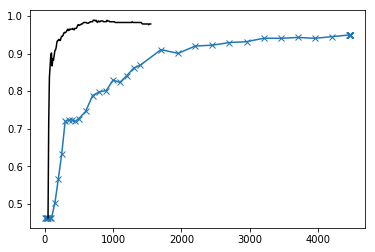

In [60]:
f1 = [i['f1'] for i in history]
num_labels = [i['num_labels'] for i in history]
plt.plot(num_labels, f1, '-x')

plt.plot([v['num_labeled'] for v in al_history_50_10], [v['f1'] for v in al_history_50_10], '-k')

In [88]:
df['X'] = df['text']

In [105]:
TH = 0.8

def run_active_learner(df, model, num_samples_in_active_learning_batch, select_next_batch_func, bootstrap):
    al_history = []
    labeled = pd.DataFrame([])

    # We first mark all data points as unused. We'll update this column whenever we already used a data point.
    df['used']= False
    df['confidence'] = 0

    df = df.sample(frac=1)
    X_all = np.array(df['X'].tolist())

    for current_batch_size in num_samples_in_active_learning_batch:
        next_labels = select_next_batch_func(df, current_batch_size)

        next_label_indices = next_labels.index
        df.loc[next_label_indices, 'used'] = True

        labeled = labeled.append(next_labels)
        next_labels['step'] = len(labeled)

        X_labeled = np.array(labeled['X'].tolist())

        print('fitting a model for {} labeled instances...'.format(len(labeled)))

        model.fit(X_labeled, y=labeled['y'].values)

        probs = model.predict_proba(X_all)
        df['confidence'] = np.max(probs, axis=1)
        df['prediction'] = model.predict(X_all)

        if bootstrap is not None:
            for i in range(bootstrap):
                confident_instances = df['confidence']>TH
                model.fit(df.loc[confident_instances]['X'],
                          y=df.loc[confident_instances]['prediction'])
                probs = model.predict_proba(X_all)
                df['confidence'] = np.max(probs, axis=1)
                df['prediction'] = model.predict(X_all)

        al_history.append({"num_labeled": len(labeled),
                        "labeled": labeled,
                        "model": model,
                        "accuracy": accuracy_score(y_true=y_test,y_pred=model.predict(X_test)),
                        "f1": f1_score(y_true=y_test,y_pred=model.predict(X_test), average='macro')
                       })

    return al_history

In [106]:
num_samples_in_active_learning_batch = [100] + [10]*50
al_history_50_10_bootstrap_1 = run_active_learner(df, model, num_samples_in_active_learning_batch, select_next_batch_func, bootstrap=1)

fitting a model for 100 labeled instances...


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:461: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


fitting a model for 110 labeled instances...


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:461: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


fitting a model for 120 labeled instances...


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:461: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


fitting a model for 130 labeled instances...


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:461: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


fitting a model for 140 labeled instances...


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:461: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


fitting a model for 150 labeled instances...


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:461: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


fitting a model for 160 labeled instances...


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:461: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


fitting a model for 170 labeled instances...


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:461: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


fitting a model for 180 labeled instances...


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:461: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


fitting a model for 190 labeled instances...


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:461: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


fitting a model for 200 labeled instances...


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:461: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


fitting a model for 210 labeled instances...


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:461: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


fitting a model for 220 labeled instances...


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:461: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


fitting a model for 230 labeled instances...


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:461: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


fitting a model for 240 labeled instances...


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:461: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


fitting a model for 250 labeled instances...


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:461: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


fitting a model for 260 labeled instances...


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:461: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


fitting a model for 270 labeled instances...


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:461: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


fitting a model for 280 labeled instances...


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:461: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


fitting a model for 290 labeled instances...


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:461: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


fitting a model for 300 labeled instances...


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


fitting a model for 310 labeled instances...
fitting a model for 320 labeled instances...
fitting a model for 330 labeled instances...
fitting a model for 340 labeled instances...
fitting a model for 350 labeled instances...
fitting a model for 360 labeled instances...
fitting a model for 370 labeled instances...
fitting a model for 380 labeled instances...
fitting a model for 390 labeled instances...
fitting a model for 400 labeled instances...
fitting a model for 410 labeled instances...
fitting a model for 420 labeled instances...
fitting a model for 430 labeled instances...
fitting a model for 440 labeled instances...
fitting a model for 450 labeled instances...
fitting a model for 460 labeled instances...
fitting a model for 470 labeled instances...
fitting a model for 480 labeled instances...
fitting a model for 490 labeled instances...
fitting a model for 500 labeled instances...
fitting a model for 510 labeled instances...
fitting a model for 520 labeled instances...
fitting a 

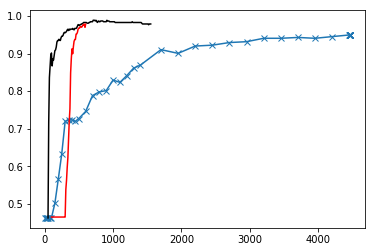

In [107]:
f1 = [i['f1'] for i in history]
num_labels = [i['num_labels'] for i in history]
plt.plot(num_labels, f1, '-x')

plt.plot([v['num_labeled'] for v in al_history_50_10], [v['f1'] for v in al_history_50_10], '-k')
plt.plot([v['num_labeled'] for v in al_history_50_10_bootstrap_1], [v['f1'] for v in al_history_50_10_bootstrap_1], '-r')